# Draft data processing

## To do

- [x] Load data
- [x] Homography

#### Data cleaning

 - [ ] Define areas in worldview plane
 - [ ] Reproject areas to video plae
 - [ ] Filter trajectories based on areas
 - [ ] Clean trajectories (How?). Iterpolation, remove outliers (e.g. points outside path)
 
#### Inference
 - [ ] Calculate speed

## Settings

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import copy as cp

In [69]:
# Import custom functions 
# from utils import *

from modules.utils import *
from modules.draw import *
from modules.homography import PixelMapper

In [3]:

# PLotting params
plt.rcParams['figure.figsize'] = [15, 10]


Functions (move this somewhere else eventually)

In [37]:
# Plot inline function for one ore two images
def imgshow(img, img2 = None):
    if img2 is None:
        plt.imshow(img)
        # plt.title('World view')
        plt.show()
    else:
        plt.subplot(1, 2, 1)
        plt.imshow(img)


        plt.subplot(1, 2, 2)
        plt.imshow(img2)

        plt.tight_layout()

        plt.show()

        
# Homography plot functions
def draw_point(img, point, color, label = None):
    img_cp = cp.deepcopy(img)
    pcoords = tuple(point)
    cv2.circle(img_cp, pcoords, 4, color, -1)
    if label is not None:
        tcoords = tuple(point + 5)
        cv2.putText(img_cp, label, tcoords,  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    # ishow(img_cp)
    return img_cp


def draw_hom_points(img, points_array):
    img_cp = cp.deepcopy(img)
    # Loop over points
    i = 0
    for p in points_array:
        i += 1
        label = 'p' + str(i)
        img_cp = draw_point(img_cp, p, (0, 0, 255), label)
    return img_cp


## Load data

Load tabular data outputed by video-processing model

In [5]:
os.listdir('data')

['2-frame.jpg', '2-sample-30min.csv', '2-sat.jpg']

In [48]:
df = pd.read_csv('data/2-sample-30min.csv')

# Calculate centroids
df['cx'] =  round(df['xi'] + (df['xj'] - df['xi'])/2).astype(int)
df['cy'] =  round(df['yi'] + (df['yj'] - df['yi'])/2).astype(int)


Load images data

In [29]:
img_frame = cv2.imread('data/2-frame.jpg')
img_world = cv2.imread('data/2-sat.jpg')


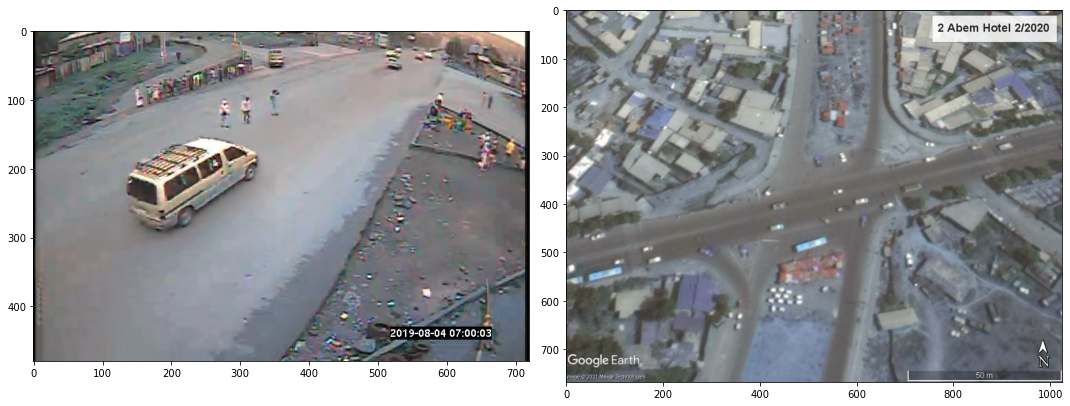

In [30]:
imgshow(img_frame, img_world)

## Homography

Homography points defintion: Set the same points in both images and coordinates

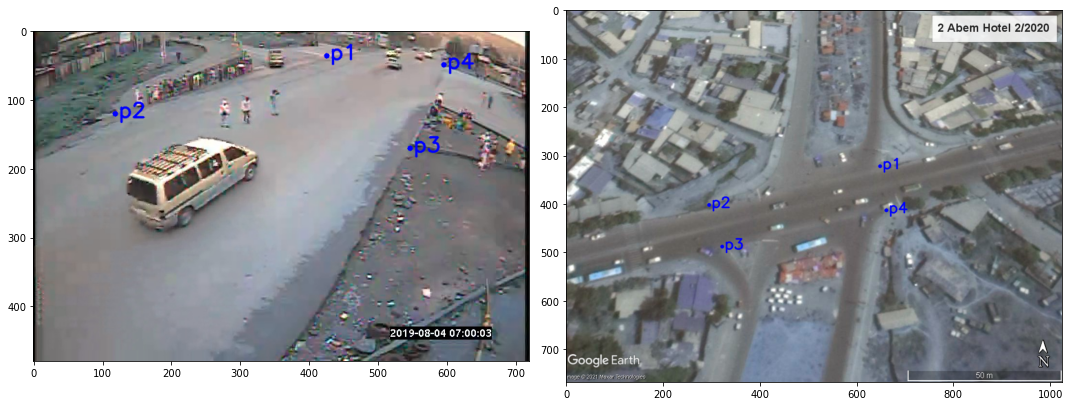

In [45]:
# Create one instance of PixelMapper to convert video frames to coordinates
quad_coords = {
    # Check these!
    "lonlat": np.array([
        [9.035947, 38.853956], # P1 top right
        [9.035794, 38.853338], # P2 top left
        [9.035631, 38.853425], # P3 bottom left
        [9.035782, 38.853971] #  P4 bottom right
    ]),
    "pixel": np.array([
        [426, 37], #  P1 top right
        [119, 121], #  P2 top left
        [547, 171], # P3 bottom left
        [596, 50] # P4 bottom right
    ]),
    "pixel_sat": np.array([
        [648, 322], # P1 top right
        [295, 402], # P2 top left
        [322, 488], #  P3 bottom left
        [661, 413] # P4 bottom right
    ])
}

# Display image points. 
img_s_points = draw_hom_points(img_world, quad_coords['pixel_sat'])
img_f_points = draw_hom_points(img_frame, quad_coords['pixel'])
imgshow(img_f_points, img_s_points)

PixelMapper class converts coordinates in pixels to lat-long

In [66]:
# Create pixel maper instance to convert from video to lat long (and vice versa)
pm = PixelMapper(quad_coords["pixel"], quad_coords["lonlat"])

# Create pixel maper instance to convert from sat image to lat long (and vice versa)
pm_sat = PixelMapper(quad_coords["pixel_sat"], quad_coords["lonlat"])

Test trajectory to see if homography is working:

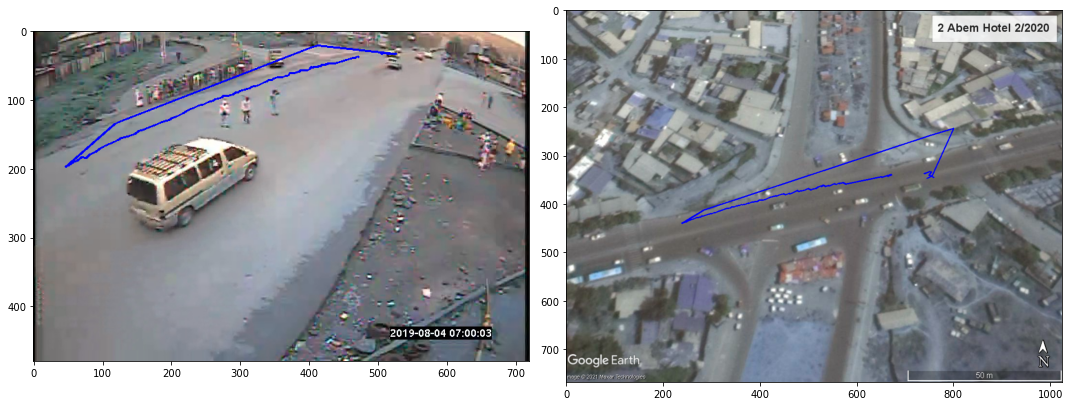

In [93]:
# To do
# - Make sure trajectories are in frame order
# - Organize this into a function



def draw_trajectory(img, trajectory_array, color):
    img_cp = cp.deepcopy(img)
    for p in range(1, len(trajectory_array)):
            cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
    return img_cp


# Create trajectory df
car_df = df[df['obj_id'] == 15]

t_car = car_df[['cx', 'cy']].to_numpy()

# Anotate trajectory on initial video frame
img_cf = img_frame.copy()
img_cf = draw_trajectory(img_cf, t_car, (0, 0, 255))

# # ishow(img_cf)

# Transform trajectories to long lat
t_car_ll = pm.pixel_to_lonlat(t_car) # t_car created in draft-intersections.py

# Transform lat long trajectory into pixels of sat image
t_car_s = pm_sat.lonlat_to_pixel(t_car_ll).astype(int)

# # Anotate trajectory on sat image
img_cs = img_world.copy()
img_cs = draw_trajectory(img_cs, t_car_s, (0, 0, 255))

imgshow(img_cf, img_cs)

In [92]:
car_df

,frame,xi,yi,xj,yj,obj_id,class,cx,cy
64,7,462,28,483,48,15,2,472,38
75,8,462,30,481,48,15,2,472,39
87,9,462,30,481,48,15,2,472,39
99,10,460,30,480,47,15,2,470,38
110,11,459,29,480,48,15,2,470,38
...,...,...,...,...,...,...,...,...,...
3458,326,490,20,522,47,15,2,506,34
3471,327,490,21,522,47,15,2,506,34
3482,328,489,20,521,47,15,2,505,34
3493,329,490,21,521,48,15,2,506,34


KeyError: 0

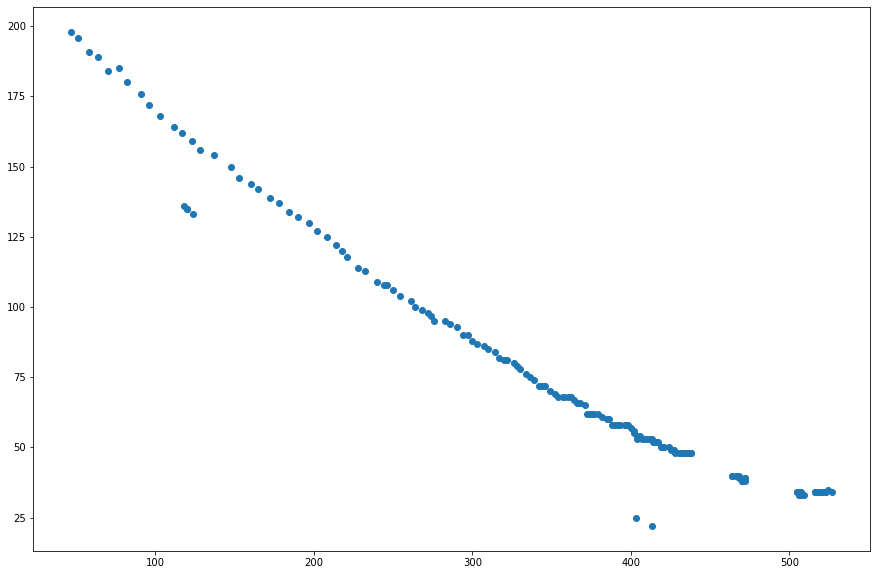

In [99]:
# y = [2.56422, 3.77284, 3.52623, 3.51468, 3.02199]
y = car_df['cy']
# z = [0.15, 0.3, 0.45, 0.6, 0.75]
x = car_df['cx']
# n = [58, 651, 393, 203, 123]
n = car_df['frame'].to_list()

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [100]:
n

[7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 212,
 213,
 214,
 215,
 247,
 248,
 274,
 275,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 317,
 318,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330]

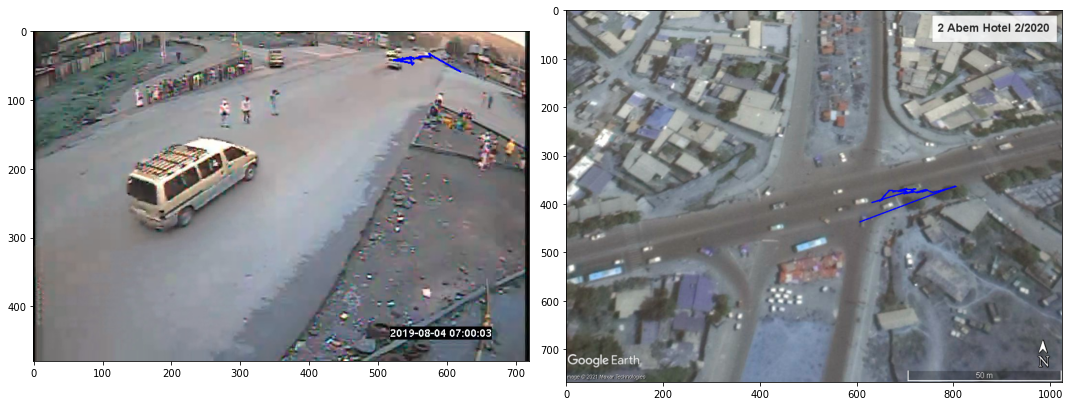

In [63]:
trajectory_array = t_car 
color = (0, 0, 255)
img_cp = cp.deepcopy(img_frame)

for p in range(1, len(trajectory_array)):
    cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
ishow(img_cp)

In [11]:
# cv2.destroyAllWindows() 

## Trajectory definition

In [12]:
df

,frame,xi,yi,xj,yj,obj_id,class
0,2,448,216,481,308,1,0
1,2,477,51,525,87,2,2
2,2,297,61,424,173,3,5
3,2,443,172,473,238,4,0
4,2,536,74,585,105,5,2
...,...,...,...,...,...,...,...
592929,54003,206,73,276,123,15548,2
592930,54003,291,385,360,479,15581,0
592931,54003,215,387,292,479,15582,0
592932,54003,349,326,399,426,15587,0


In [13]:
p = tuple(df.loc[592932][['yi','xi']]); p

(326, 349)

In [14]:
df.loc[592932]

frame     54003
xi          349
yi          326
xj          399
yj          426
obj_id    15587
class         0
Name: 592932, dtype: int64

In [26]:
img_frame_a = cp.deepcopy(img_frame)
img_frame_a = cv2.circle(img_frame, tuple(p), radius=1, color=(0, 255, 255), thickness=10)


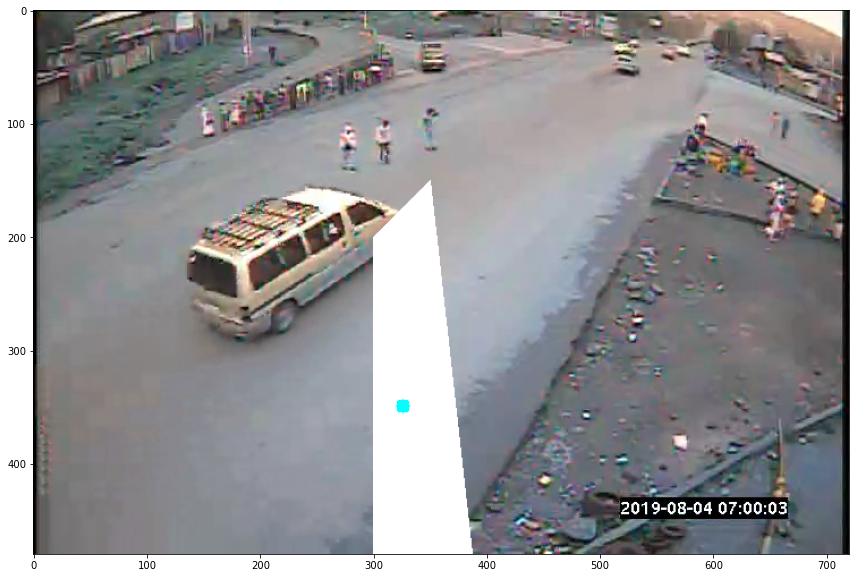

In [27]:
plt.imshow(img_frame_a)
plt.show()

In [28]:
# Define temporary area

# #  Point outside
# contours = np.array([[50,50], [50,150], [150,150], [150,50]])

# Point inside
contours = np.array([[300,200], # top left 
                     [300,500], # top rignt
                     [400,600], # bottom right
                     [350,150]]) # bottom left

# image = np.zeros((200,200))
# image = cv2.fillPoly(img_frame_a, pts = [contours], color =(255,255,255))
# imgshow(image)

In [18]:

# To fo
#  - Display with transparency!
#  - Draw with mouse clicks!

In [19]:
# Test if point in area
cv2.pointPolygonTest(contours, p, False) 

1.0

In [20]:
# Test if any point from that object trajectory is inside 

# Getting the top right corner
obj_1 = df[df['obj_id'] == 1][['xi', 'yi']]

# obj_1.iloc[0]

# Test each point individually. Try a more efficient way!
for i in range(0, len(obj_1)):
    p_i = tuple(obj_1.iloc[i])
    bol = cv2.pointPolygonTest(contours, p_i, False) 
    print(p_i)

(448, 216)
(448, 216)
(448, 215)
(457, 204)
(460, 200)
(462, 198)
(463, 196)
(464, 196)
(464, 196)
(464, 195)
(464, 194)
(466, 194)
(465, 193)
(465, 193)
(466, 193)
(468, 193)
(469, 192)
(470, 192)
(471, 192)
(471, 192)
(471, 191)
(470, 190)
(470, 188)
(470, 187)
(472, 186)
(472, 186)
(473, 185)
(472, 185)
(472, 183)
(473, 182)
(472, 181)
(474, 179)
(475, 179)
(475, 178)
(476, 177)
(476, 177)
(477, 176)
(477, 176)
(478, 174)
(478, 173)
(477, 171)
(477, 169)
(477, 168)
(478, 169)
(478, 168)
(478, 168)
(481, 168)
(484, 171)
(485, 172)
(486, 172)
(488, 172)
(489, 171)
(489, 170)
(489, 168)
(489, 167)
(489, 166)
(491, 167)
(490, 166)
(492, 165)
(492, 164)
(493, 164)
(492, 163)
(492, 162)
(495, 164)
(495, 163)
(497, 162)
(498, 161)
(496, 161)
(495, 160)
(495, 160)
(498, 159)
(499, 159)
(497, 158)
(496, 156)
(496, 155)
(496, 153)
(497, 153)
(501, 155)
(503, 155)
(504, 155)
(504, 155)
(505, 154)
(506, 154)
(508, 155)
(509, 156)
(509, 155)
(509, 155)
(509, 154)
(509, 152)
(510, 151)
(510, 150)

In [21]:
len(obj_1)

133

# DRAFT

In [10]:
#----------------------------------------------------
# Use mouse to find points (or try to at least)


# Marker and grab position function

img = cp.deepcopy(img_frame)
mouseX,mouseY = 0,0

def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img,(x,y),3,(255,0,0),1)
        mouseX,mouseY = x,y
        

# A window that will capture the mouse click
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw_circle)

# while(1):
#     cv2.imshow('image',img)
#     # Kill window if Q is pressed
#     k = cv2.waitKey(1) & 0xFF
#     if k == ord('q'):
#         cv2.destroyAllWindows()
#         break
#     elif k == ord('a'):
#         print(mouseX,mouseY)
# print(mouseX,mouseY)

362 269
